# TODO
* [ ] Correrlo con `max_iter = 5_000`
* [ ] Hacer la versión Batch
* [ ] Hacer la versión proyectada

Notebook que sirve de ejemplo para calcular el baricentro de un conjunto de datos de imágenes.

# Configuraciones iniciales

## Constantes

In [1]:
NOTEBOOK = 2
CLEAN_LOGS = True  # If you want to clean the logs directory
SAVE_FIGS = True  # If you want to save the figures.

REPORT_EVERY = 100  # To report at the logger
MAX_ITER = 5_000  # MAx number of iterations for the SGDW
BATCH_SIZE = 25

MAX_ITER = 50; REPORT_EVERY = 5  # Descomentar para debuguear

In [2]:
import torch
import numpy as np
import random

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True

In [3]:
from pathlib import Path
from icecream import ic


DS_NAME = "data"

CURR_PATH = Path().absolute()
ic(CURR_PATH)
BASE_PATH = CURR_PATH.parent.parent
ic(BASE_PATH)
DATA_PATH = BASE_PATH / "data"
ic(DATA_PATH)
WGAN_PATH = BASE_PATH / "wgan_gp"
ic(WGAN_PATH)
NETS_PATH = WGAN_PATH / "networks" 
ic(NETS_PATH)
IMGS_PATH = CURR_PATH / "imgs" / f"notebook-{NOTEBOOK:02d}"
IMGS_PATH.mkdir(parents=True, exist_ok=True)
ic(IMGS_PATH)

ic| CURR_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/03-sgdw')
ic| BASE_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters')
ic| DATA_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/data')
ic| WGAN_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp')
ic| NETS_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/networks')
ic| IMGS_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/03-sgdw/imgs/notebook-02')


PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/03-sgdw/imgs/notebook-02')

## Importaciones generales

In [4]:
from bwb import utils
from bwb.sgdw import sgdw
from bwb.distributions import *
from bwb.transports import *
import torch
import bwb.plotters as plotters
import bwb.sgdw.plotters as sgdw_plotters

## Configuraciones 

In [5]:
from bwb.config import conf

conf.use_cpu()
conf.use_single_precision()
conf.set_eps(1e-16)
conf

Config(dtype=torch.float32, device=cpu, eps=1.00e-16)

## Configuración del Logger

In [6]:
import time
from pathlib import Path


# Create the logs directory
LOG_PATH = Path("logs") / f"notebook-{NOTEBOOK:02d}_{time.strftime('%Y%m%d_%H%M%S')}.log"
if not LOG_PATH.parent.exists():
    LOG_PATH.parent.mkdir()

# Clean the logs
if CLEAN_LOGS:
    for log_file in Path("logs").glob(f"notebook-{NOTEBOOK:02d}*.log"):
        log_file.unlink()

In [7]:
import logging
from bwb._logging import log_config


# Remove the handlers
log_config.remove_all_handlers()

# Define and add FileHandler
fh = logging.FileHandler(LOG_PATH)
log_config.set_default_formatter(fh)
log_config.add_handler(fh)


_log = log_config.get_logger("notebook")
log_config.set_level(level=logging.DEBUG, name="notebook")
log_config.set_level(level=logging.INFO, name="bwb.utils")
log_config.set_level(level=logging.DEBUG, name="bwb.sgdw.sgdw")
log_config.set_level(level=logging.DEBUG, name="bwb.sgdw.plotters")
log_config.set_level(level=logging.INFO, name="bwb.transports")

Esta celda es para configurar la información mostrada en el logger

In [8]:
# Set the default options for the report
INCLUDE_OPTIONS: sgdw.ReportOptions = {
    "dt": False,
    "dt_per_iter": True,
    "iter": True,
    "step_schd": True,
    "total_time": True,
    "w_dist": False,
}

sgdw.Report.INCLUDE_OPTIONS = INCLUDE_OPTIONS

## Obtención del dataset

ic| file_path: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/dataset/cleaned/data.npy')
ic| len(dataset): 195479


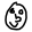

In [9]:
# You can use the wrapper to transform the usual DataSet into a model set
from bwb.distributions.models import ModelDataset
import quick_torch as qt
import torchvision.transforms.v2 as T

transform_ds = T.Compose([
    T.Resize((32, 32)),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Lambda(lambda x: x.squeeze()),
])

def get_ds(file_path, transform=transform_ds):
    ic(file_path)
    categories = [qt.Category.FACE]
    dataset_ = qt.QuickDraw(
        root=DATA_PATH,
        categories=categories,
        transform=transform,
        download=True,
        recognized=True,
    )
    path_dataset = Path(file_path)
    dataset_.data = np.load(path_dataset).reshape(-1, 28, 28)
    dataset_.targets = np.ones(len(dataset_.data), dtype=int)
    dataset = dataset_.get_train_data()
    ic(len(dataset))

    return ModelDataset(dataset)

DS_PATH = WGAN_PATH / "dataset" / "cleaned" / f"{DS_NAME}.npy"
ds_models = get_ds(DS_PATH)

ds_models.get(0)

In [10]:
ds_models

ModelDataset(device=cpu, dtype=torch.float32, dataset=Dataset QuickDraw
    Number of datapoints: 195479
    Root location: /home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/data
    StandardTransform
Transform: Compose(
                 Resize(size=[32, 32], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToImage()
                 ToDtype(scale=True)
                 Lambda(<lambda>, types=['object'])
           ))

## Obtener GAN

De la misma manera, se puede definir un muestreador de distribuciones utilizando una GAN. Para ello, empezamos definiendo las redes neuronales a utilizar

In [18]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder, LatentDistribution
import torch
from wgan_gp.wgan_gp_vae.utils import load_checkpoint


device = conf.device

NOISE = "norm"
LATENT_DIM = 128
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

noise_sampler = LatentDistribution(NOISE, LATENT_DIM, device)

DS_NAME = "data"

G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

FACE_PATH = NETS_PATH / f"cleaned_{DS_NAME}_zDim{LATENT_DIM}_{NOISE}_bs_128"
ic(FACE_PATH)

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(); E.eval()
print()

ic| FACE_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/networks/cleaned_data_zDim128_norm_bs_128')


In [19]:
noise_sampler

LatentDistribution(name=norm, z_dim=128, device=cpu, seed=1725758495225533308)

torch.float64


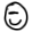

In [20]:
from bwb.distributions import DistributionDraw
from torchvision import disable_beta_transforms_warning
disable_beta_transforms_warning()

import torchvision.transforms.v2 as T


z = noise_sampler(1)
m = G(z)

transform_in = T.Compose([
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize(32),
    T.ToImage(),
    T.ConvertImageDtype(torch.float32),
    T.Normalize((0.5,), (0.5,)),
])

transform_out_ = T.Compose([
    T.ToDtype(torch.float64),
    T.Lambda(lambda x: x.squeeze()),
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
])

transform_out = T.Compose([
    transform_out_,
    T.Lambda(lambda x: DistributionDraw.from_grayscale_weights(x)),
])


out: DistributionDraw = transform_out(m)
print(out.dtype)
out

## Definir $\gamma_k$

Aquí se utiliza una función de la forma
\begin{equation*}
    \gamma_k = \frac{a}{(b^{1/c} + k)^c}
\end{equation*}

Con $a > 0$, $b \geq 0$ y $0.5 < c \leq 1$

La idea es que cuando $k=0$, $\gamma_0 = \frac{a}{b}$ es la proporción entre $a$ y $b$, permitiendo ajustar el valor inicial.

In [11]:
from bwb.sgdw.utils import step_scheduler
window = 5

def test_gamma(gamma):

    for t in range(window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 50
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 100
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 300
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 500
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 1_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 3_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 5_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()


_a = 3
_eps = 1e-3
params = dict(a=_a, b=_a+1e-2, c=0.5+_eps)
# params = dict(a=1, b=1, c=1)

gamma = step_scheduler(**params)

test_gamma(step_scheduler(**params))

t = 0; gamma(t) = 99.67%
t = 1; gamma(t) = 94.55%
t = 2; gamma(t) = 90.15%
t = 3; gamma(t) = 86.31%
t = 4; gamma(t) = 82.93%

t = 50; gamma(t) = 38.89%
t = 51; gamma(t) = 38.57%
t = 52; gamma(t) = 38.25%
t = 53; gamma(t) = 37.94%
t = 54; gamma(t) = 37.63%

t = 100; gamma(t) = 28.60%
t = 101; gamma(t) = 28.47%
t = 102; gamma(t) = 28.34%
t = 103; gamma(t) = 28.21%
t = 104; gamma(t) = 28.09%

t = 300; gamma(t) = 16.97%
t = 301; gamma(t) = 16.94%
t = 302; gamma(t) = 16.91%
t = 303; gamma(t) = 16.89%
t = 304; gamma(t) = 16.86%

t = 500; gamma(t) = 13.21%
t = 501; gamma(t) = 13.20%
t = 502; gamma(t) = 13.19%
t = 503; gamma(t) = 13.18%
t = 504; gamma(t) = 13.16%

t = 1_000; gamma(t) = 9.38%
t = 1_001; gamma(t) = 9.37%
t = 1_002; gamma(t) = 9.37%
t = 1_003; gamma(t) = 9.37%
t = 1_004; gamma(t) = 9.36%

t = 3_000; gamma(t) = 5.43%
t = 3_001; gamma(t) = 5.42%
t = 3_002; gamma(t) = 5.42%
t = 3_003; gamma(t) = 5.42%
t = 3_004; gamma(t) = 5.42%

t = 5_000; gamma(t) = 4.20%
t = 5_001; gamma(t) = 4.2

# Baricentro de imágenes

Para obtener el baricentro de un conjunto de imágenes, es necesario utilizar la clase `UniformDiscreteSampler` y fijarla con una clase que tenga los siguientes métodos:
* `get(i) -> Distribution` que retorne la distribución $i$-ésima.
* `__len__() -> int` que retorne el tamaño del dataset.

In [12]:
distr_sampler = UniformDiscreteSampler[DistributionDraw]().fit(models=ds_models)

Luego definimos el algoritmo a utilizar. En este caso, utilizaremos `DebiesedDistributionDrawSGDW` que realiza los transportes utilizando un método convolución debiesed. 

In [13]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=distr_sampler,
    step_scheduler=step_scheduler(**params),
    batch_size=BATCH_SIZE,
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

(DetentionParameters(tol=0.00e+00, max_iter=50, max_time=∞),
 History(pos_wgt=False, distr=False, pos_wgt_samp=False, distr_samp=False, len=0))

Definimos una clase para comparar las imágenes de las muestras con la iteración del algoritmo.

In [14]:
from bwb.sgdw.plotters import PlotterComparison

plotter_comp = PlotterComparison(
    dist_draw_sgdw,
    n_cols=12,
    n_rows=1,
    cmap="binary_r"
)

In [15]:
_log.info(f"Running SGD-Wasserstein with '{DS_NAME}' DS barycenter")
bar = plotter_comp.run(include_dict=dict(total_time=True))
dist_draw_sgdw.iter_params

IterationParameters(k=50, w_dist=∞, t=0:00:16.69, Δt=318.79 [ms])

Obtenemos una visualización de las primeras imágenes.

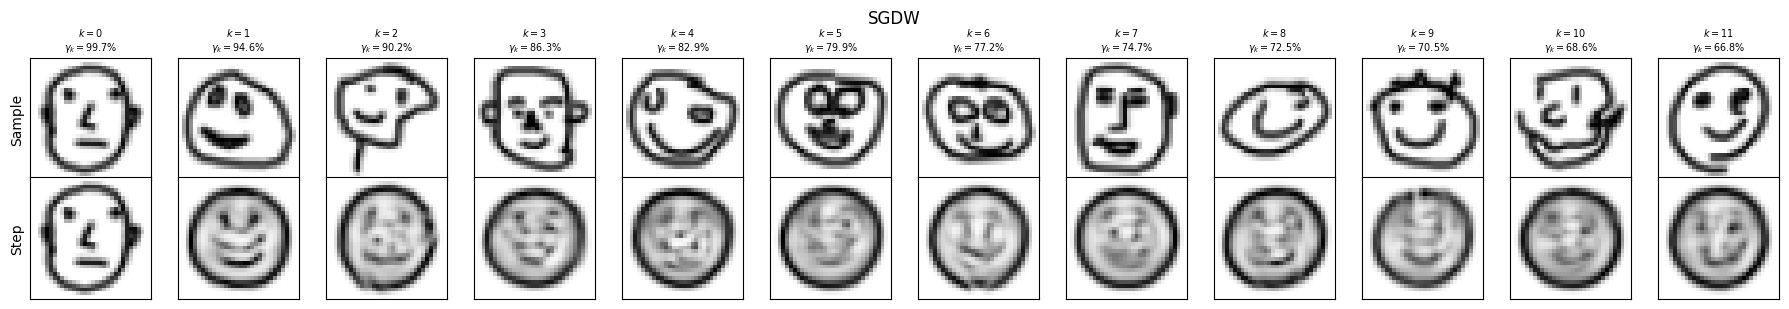

In [16]:
_ = plotter_comp.plot(0)

Obtenemos una visualización de las últimas imágenes.

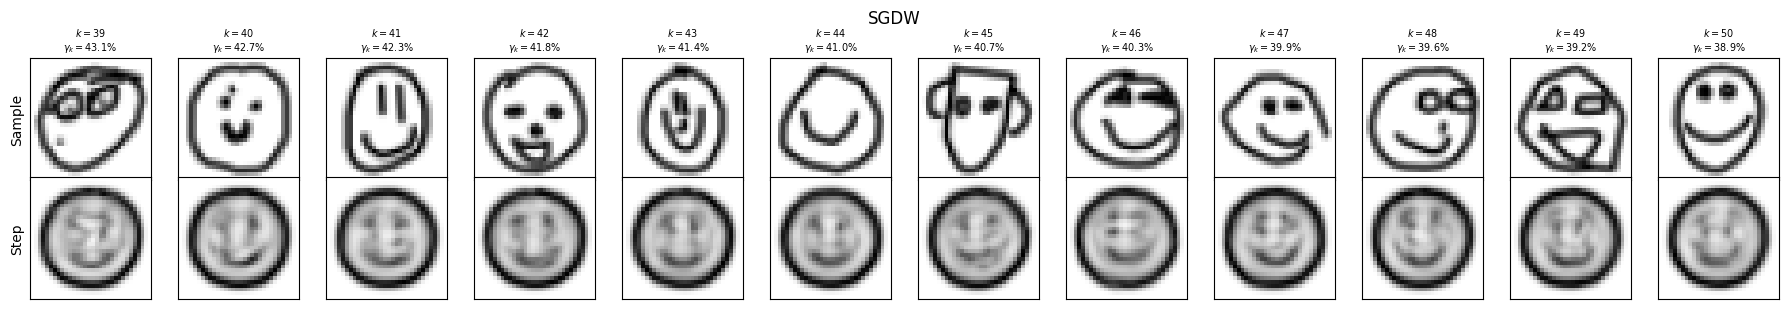

In [17]:
_ = plotter_comp.plot()

# Baricentro de la GAN

## Definir el algoritmo

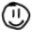

In [21]:
distr_sampler = GeneratorDistribSampler()
distr_sampler.fit(generator=G, noise_sampler=noise_sampler, transform_out=transform_out_)
distr_sampler.draw()

In [22]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=distr_sampler,
    step_scheduler=step_scheduler(**params),
    batch_size=BATCH_SIZE,
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

(DetentionParameters(tol=0.00e+00, max_iter=50, max_time=∞),
 History(pos_wgt=False, distr=False, pos_wgt_samp=False, distr_samp=False, len=0))

Definimos una clase para comparar las imágenes de las muestras con la iteración del algoritmo.

In [23]:
from bwb.sgdw.plotters import PlotterComparison

plotter_comp = PlotterComparison(
    dist_draw_sgdw,
    n_cols=12,
    n_rows=1,
    cmap="binary_r"
)

In [24]:
_log.info(f"Running SGD-Wasserstein with '{DS_NAME}' DS barycenter")
bar = plotter_comp.run(include_dict=dict(total_time=True))
dist_draw_sgdw.iter_params

IterationParameters(k=50, w_dist=∞, t=0:00:37.86, Δt=716.53 [ms])

Obtenemos una visualización de las primeras imágenes.

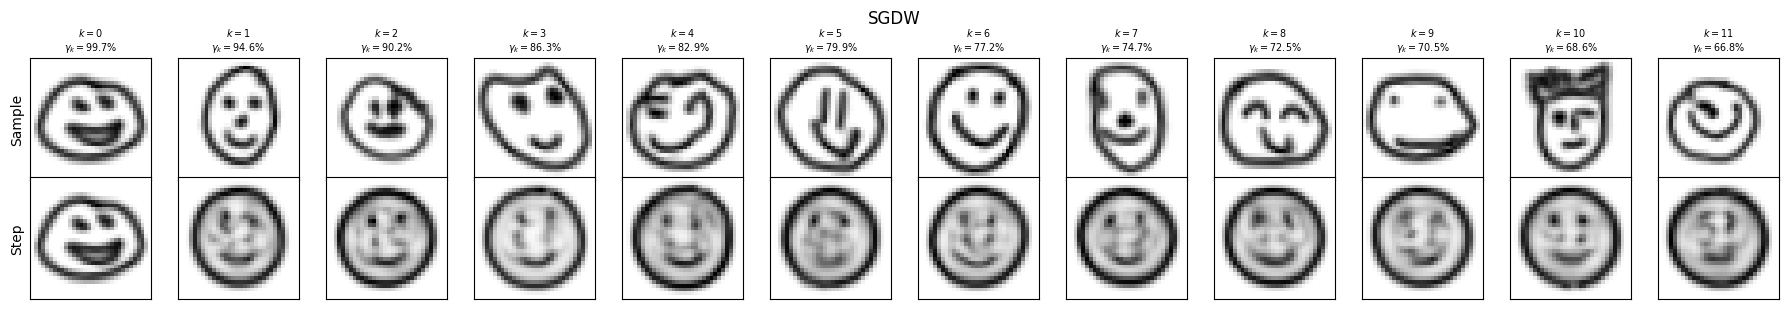

In [25]:
_ = plotter_comp.plot(0)

Obtenemos una visualización de las últimas imágenes.

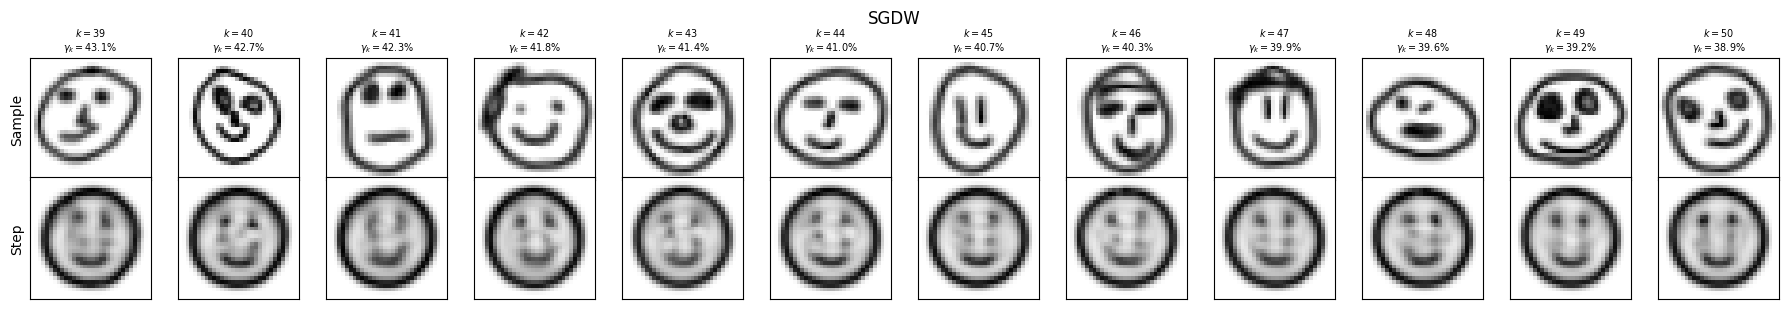

In [26]:
_ = plotter_comp.plot()